In [2]:
import matplotlib.pyplot as plt
import numpy as np
import photovoltaic as pv
from numpy import radians as rad
import pandas as pd

In [3]:
module_azimuth = 180
module_elevation = 33

In [4]:
def elev_azi(declination, latitude, local_solar_time):
    """Return the elevation (degrees) and azimuth (degrees)"""
    hour_angle = 15.0 * (local_solar_time - 12.0)
    elevation = arcsind(sind(declination) * sind(latitude) + cosd(declination) * cosd(latitude) * cosd(hour_angle))
    azimuth = arccosd(
        (cosd(latitude) * sind(declination) - cosd(declination) * sind(latitude) * cosd(hour_angle)) / cosd(elevation))
    # the multiplication by 1.0 causes a single value return for single inputs, otherwise it returns an array of one element
    azimuth = np.where(hour_angle > 0, 360.0 - azimuth, azimuth) * 1.0
    return elevation, azimuth

In [5]:
def sun_position(dayNo, latitude, longitude, GMTOffset, H, M):
    """ return the position of the sun as a elevation and azimuth given
    latitude, logitude and the GMTOffset, """
    EoT = equation_of_time(dayNo)
    TimeCorrection = time_correction(EoT, longitude, GMTOffset)
    local_solar_time = H + (TimeCorrection + M) / 60.0
    elevation, azimuth = elev_azi(declination(dayNo), latitude, local_solar_time)
    return elevation, azimuth

In [6]:
def equation_of_time(day_no):
    """return the equation of time (minutes)
    given the day number """
    B = 360.0 / 365.0 * (day_no - 81.0)
    EoT = 9.87 * sind(2 * B) - 7.53 * cosd(B) - 1.5 * sind(B)
    # print('EoT', EoT)
    return EoT

In [7]:
def time_correction(EoT, longitude, GMTOffset):
    """ Return the time correction in minutes
    given the location longitude and the GMT offset (hours)"""
    LSTM = 15.0 * GMTOffset
    TimeCorrection = 4.0 * (longitude - LSTM) + EoT
    return TimeCorrection

In [8]:
def elevation(declination, latitude, local_solar_time):
    """ Return the elevation angle of the sun (degrees)
    given declination (degrees), latitude (degrees) and hour angle of sun (hours) """
    hra = 15.0 * (local_solar_time - 12.0)
    return arcsind(sind(declination) * sind(latitude) + cosd(declination) * cosd(latitude) * cosd(hra))

In [9]:
fname = '724460tya.csv'
print(fname)

724460tya.csv


In [10]:
station, GMT_offset, latitude, longitude, altitude = np.genfromtxt(fname, max_rows=1, delimiter=",", usecols=(0, 3, 4, 5, 6))
location_name, location_state = np.genfromtxt(fname, max_rows=1, delimiter=",", usecols=(1,2), dtype= np.str)
ETR, GHI, DNI, DHI, ambient_temperature = np.genfromtxt(fname, skip_header=2, delimiter=",", usecols=(2,4,7, 10,31), unpack=True)

In [11]:
# Print Information about the TMY Data
print('Location information:')
print(' station number: ', station)
print(' Station Name and State: ', location_name, " ", location_state)
print(' GMT: ', GMT_offset)
print('Latitude (degrees): ', latitude)
print('Longitude (degreees): ', longitude)
print('Altitude (m): ', altitude)
print('\n')

Location information:
 station number:  724460.0
 Station Name and State:  "KANSAS CITY INT'L ARPT"   MO
 GMT:  -6.0
Latitude (degrees):  39.3
Longitude (degreees):  -94.717
Altitude (m):  298.0




In [12]:
print(' Latitude : {:.1f}°, Longitude: {:.1f}°, \n Module tilt angle: {}°, Module azimuth: {}°'.format(
              latitude, longitude, module_elevation, module_azimuth)) 

 Latitude : 39.3°, Longitude: -94.7°, 
 Module tilt angle: 33°, Module azimuth: 180°


In [13]:
# details for the plots
details4plot =  ' lat: {:.1f}°, long: {:.1f}°, Module el: {}°, az: {}°'.format(
              latitude, longitude, module_elevation, module_azimuth)

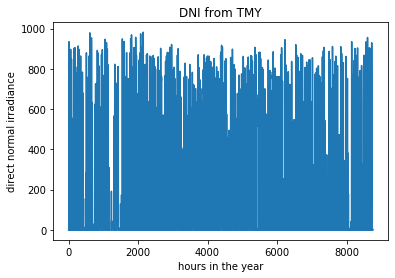

In [14]:
# plot the TMY data. Note we cheated and didn't specify an x-axis, since it is just numbered from 0 to 8760.
# Can't do this if time interval other than 1 hour
plt.figure('DNI from TMY')
plt.title('DNI from TMY')
plt.xlabel('hours in the year')
plt.ylabel('direct normal irradiance')
plt.plot(DNI)

In [15]:
module_elevation = latitude

In [16]:
# *********************      Calculating solar angles  ********************************
# The big part of these calculations is getting the day and hour correct.

# Some ways to get the day and hours into an array  (1) read date and time from data file into an array that has day number and then hour of the day;
#                                                   (2) Generate an array with day number and hour of the year. 

# The following generates two arrays, each with 8760 data points. The hours of the day array has a repeating sequence of hours
# We generate the hours 1 to 24 365 times. So the array  goes 1,2, ... 24, 1, 2, 3, ... 24,  Total 8760 data points.
hours = np.arange(1,25) # Generate an array with the values 1 to 24
hour_of_day = np.tile(hours,365) # Generate an array with the hours 1 to 24 repeated 365 times

# Create an array  day 1 is repeated 24 times, day2 is repeated 24 times etc, so have 1 24 times, then 2 24 times,etc.
days = np.arange(1,366)
day_no = np.repeat(days,24)

In [17]:
elevations, azimuths = pv.sun.sun_position(day_no, latitude, longitude, GMT_offset, hour_of_day, 0)
fraction_normal_to_module = pv.sun.module_direct(azimuths,elevations,module_azimuth,module_elevation)
DNI_module = DNI * fraction_normal_to_module
diffuse_module = DHI * (180 - module_elevation) / 180
total_module = diffuse_module + DNI_module

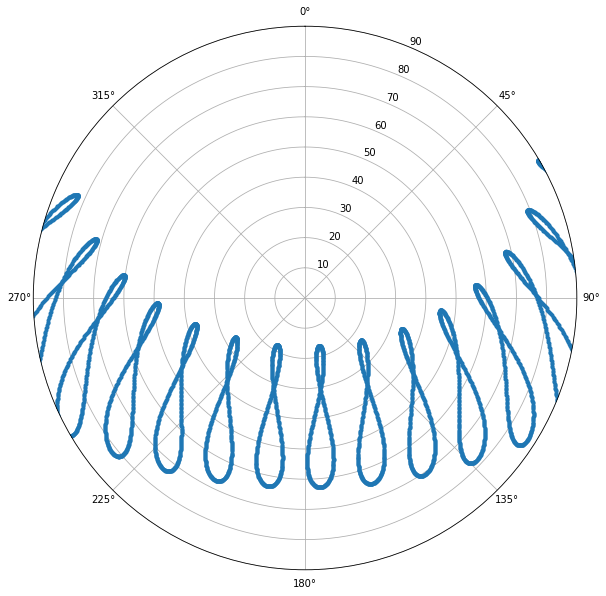

In [18]:
plt.figure('solar_path_' + str(latitude), figsize=(10, 10))
ax = plt.subplot(111, projection='polar')
ax.plot(rad(azimuths),90.0-elevations, marker='.', linestyle='None')
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.set_rmax(90)
ax.grid(True)

In [19]:
# Calculate Summary Location Parameters 

fraction_diffuse_module = diffuse_module/(DNI_module+ 1e-9 + diffuse_module)
fraction_diffuse = DHI/(GHI + 1e-9)

In [20]:
print('\n')
print('Summary Information for Solar Radiation:')

print(f' Capacity Factor (maximum) {sum(0.1*GHI/8760):.2f} %')
print(f' Yearly fraction of diffuse on module {100* sum(diffuse_module)/sum(DNI_module+diffuse_module):.2f} %')
print(f' Yearly fraction of diffuse {100* sum(DHI)/sum(GHI + 1e-9):.2f} %')



Summary Information for Solar Radiation:
 Capacity Factor (maximum) 18.12 %
 Yearly fraction of diffuse on module 28.67 %
 Yearly fraction of diffuse 37.93 %


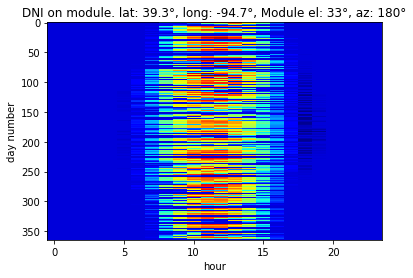

In [21]:
# make nice heat map plots
# we need to take the 1D arrays and convert to 2D arrays

plt.figure('DNI on module')
plt.title('DNI on module.'+details4plot)
DNI_module_2D = DNI_module.reshape(-1,24)
plt.xlabel('hour')
plt.ylabel('day number')
plt.imshow(DNI_module_2D, cmap='jet', aspect='auto')